### Import Libraries

In [1]:
import os 
import torch 
import torch.nn as nn
import torchmetrics
import torchvision
from torchvision.transforms import transforms
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split

import pydicom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Data Preperation

In [2]:
# Define the data dir and labels file
data_dir = "Data/rsna-pneumonia-detection-challenge/stage_2_train_images/"
labels = "Data/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"

In [3]:
# Read in data 
labels_df = pd.read_csv(labels)
labels_df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [4]:
# Data transormation pipelines for data preprocessing
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomAffine(degrees=(-5,5), translate=(0, 0.05), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop((224, 224), scale=(0.25, 1), antialias=True)
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

#### Custom Dataset

In [28]:
# Define custom dataset class
class PneumoniaDataset(Dataset):
    def __init__(self, data_dir, labels_df, transforms=None):
        self.data_dir = data_dir
        self.labels_df = labels_df
        self.transforms = transforms
    
    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        # Get the filename for the corresponding index
        filename = self.labels_df.loc[idx, "patientId"] + ".dcm"
        # Create path to the image file
        path = os.path.join(self.data_dir, filename)
        # Read the DICOM file
        dcm = pydicom.dcmread(path)
        # Extract the pixel array from the DICOM file
        img = dcm.pixel_array

        if self.transforms is not None:
            # Apply the specified transforms to the image
            img = self.transforms(img)
        
        # Extract the label from the "Target" column
        label = self.labels_df.loc[idx, "Target"]
        return img, label


In [34]:
# Define variables
batch_size = 64
num_workers = 4

# Split data into train and validation
train_df, val_df = train_test_split(labels_df, test_size=0.1, random_state=42)

# Create datasets
train_dataset = PneumoniaDataset(data_dir, train_df)
val_dataset = PneumoniaDataset(data_dir, val_df)
         

In [35]:
# Apply transforms
train_dataset.transforms = train_transforms
val_dataset.transforms = val_transforms

In [36]:
# Apply transforms
train_dataset.transforms = train_transforms
val_dataset.transforms = val_transforms      

##### Preview images

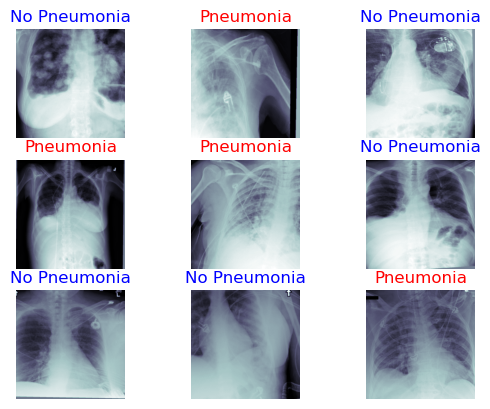

In [37]:
# Select random images
import random
random_indices = random.sample(range(len(train_dataset)), 9)

# Retrieve corresponding images and labels
images = [train_dataset[i][0] for i in random_indices]
labels = [train_dataset[i][1] for i in random_indices]
for i, image in enumerate(images):
    plt.subplot(3, 3, i+1)
    plt.imshow(image.squeeze(), cmap="bone")
    if labels[i]:
        plt.title("Pneumonia", color="red")
    else:
        plt.title("No Pneumonia", color="blue")
    plt.axis('off')
plt.show()

In [38]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True
) 

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False
)     